# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### Reading AZDIAS and CUSTOMERS dataset

In [2]:
# load in the data
#azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
#customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

In [3]:
# save as pickle for faster load times 
#azdias.to_pickle('azdias.pickle')
#customers.to_pickle('customers.pickle')

In [4]:
# load in the data from pickle
azdias = pd.read_pickle('azdias.pickle')
customers = pd.read_pickle('customers.pickle')

AZDIAS dataset:

In [5]:
azdias.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
print("Azdias dataset contains of {} features and {} rows".format(azdias.shape[1], azdias.shape[0]))

Azdias dataset contains of 366 features and 891221 rows


In [7]:
# Get azdias column datatypes
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

In [8]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,8.912210e+05,891221.000000,817722.000000,817722.000000,81058.000000,29499.000000,6170.000000,1205.000000,628274.000000,798073.000000,...,770025.000000,815304.000000,815304.000000,815304.000000,783619.000000,817722.000000,798073.000000,891221.000000,891221.000000,891221.000000
mean,6.372630e+05,-0.358435,4.421928,10.864126,11.745392,13.402658,14.476013,15.089627,13.700717,8.287263,...,2.417322,6.001214,7.532130,5.945972,3.933406,7.908791,4.052836,3.362438,1.522098,2.777398
std,2.572735e+05,1.198724,3.638805,7.639683,4.097660,3.243300,2.712427,2.452932,5.079849,15.628087,...,1.166572,2.856091,3.247789,2.771464,1.964701,1.923137,1.949539,1.352704,0.499512,1.068775
min,1.916530e+05,-1.000000,1.000000,0.000000,2.000000,2.000000,4.000000,7.000000,0.000000,0.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000
25%,4.144580e+05,-1.000000,1.000000,0.000000,8.000000,11.000000,13.000000,14.000000,11.000000,1.000000,...,2.000000,3.000000,5.000000,4.000000,2.000000,8.000000,3.000000,3.000000,1.000000,2.000000
50%,6.372630e+05,-1.000000,3.000000,13.000000,12.000000,14.000000,15.000000,15.000000,14.000000,4.000000,...,2.000000,6.000000,8.000000,6.000000,4.000000,9.000000,3.000000,3.000000,2.000000,3.000000
75%,8.600680e+05,-1.000000,9.000000,17.000000,15.000000,16.000000,17.000000,17.000000,17.000000,9.000000,...,3.000000,9.000000,10.000000,8.000000,6.000000,9.000000,5.000000,4.000000,2.000000,4.000000
max,1.082873e+06,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,595.000000,...,4.000000,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,2.000000,9.000000


CUSTOMERS dataset:

In [9]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
customers.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [10]:
print("Customers dataset contains of {} features and {} rows".format(customers.shape[1], customers.shape[0]))

Customers dataset contains of 369 features and 191652 rows


In [11]:
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

In [12]:
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
count,191652.000000,191652.000000,145056.000000,145056.000000,11766.000000,5100.000000,1275.000000,236.000000,139810.000000,141725.000000,...,143781.000000,143781.000000,143781.000000,137910.000000,145056.000000,141725.000000,191652.000000,191652.000000,191652.000000,191652.000000
mean,95826.500000,0.344359,1.747525,11.352009,12.337243,13.672353,14.647059,15.377119,10.331579,4.965863,...,4.374417,4.564769,3.168868,4.152716,8.646371,3.723133,2.576806,0.090247,1.376432,3.060907
std,55325.311233,1.391672,1.966334,6.275026,4.006050,3.243335,2.753787,2.307653,4.134828,14.309694,...,2.924355,2.887035,2.233516,1.974375,1.154001,2.095540,1.168486,0.286536,0.484492,1.086254
min,1.000000,-1.000000,1.000000,0.000000,2.000000,2.000000,5.000000,8.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000
25%,47913.750000,-1.000000,1.000000,8.000000,9.000000,11.000000,13.000000,14.000000,9.000000,1.000000,...,2.000000,2.000000,1.000000,2.000000,9.000000,2.000000,1.000000,0.000000,1.000000,3.000000
50%,95826.500000,0.000000,1.000000,11.000000,13.000000,14.000000,15.000000,16.000000,10.000000,1.000000,...,4.000000,4.000000,3.000000,5.000000,9.000000,3.000000,3.000000,0.000000,1.000000,3.000000
75%,143739.250000,2.000000,1.000000,16.000000,16.000000,16.000000,17.000000,17.000000,13.000000,4.000000,...,7.000000,7.000000,4.000000,6.000000,9.000000,5.000000,3.000000,0.000000,2.000000,4.000000
max,191652.000000,3.000000,9.000000,21.000000,18.000000,18.000000,18.000000,18.000000,25.000000,523.000000,...,11.000000,13.000000,11.000000,6.000000,9.000000,8.000000,6.000000,1.000000,2.000000,9.000000


### Data wrangling

AZDIAS dataset:

#### Drop unknown columns

The dataset `DIAS Information Levels - Attributes 2017` contains information and explanations to most features of the azdias dataset. As I want to focus on features whose meaning I know, I restrict myself on features described in the dataset.

In [13]:
# read the attributes dataset
attributes_df = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx', header = 1, usecols='C:D', dtype='str')
attributes_df.head(5)

,Attribute,Description
0,AGER_TYP,best-ager typology
1,ALTERSKATEGORIE_GROB,age through prename analysis
2,ANREDE_KZ,gender
3,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...
4,FINANZ_MINIMALIST,financial typology: low financial interest


In [14]:
# get all listed attributes
attribute_list = attributes_df['Attribute'].tolist()
len(attribute_list)

313

In [15]:
# get all attributes from AZDIAS which are not listed
azdias_not_in_attribute_list = list(set(azdias) - set(attribute_list))
len(azdias_not_in_attribute_list)

102

In [16]:
# drop unlisted attributes from azdias
azdias.drop(labels=azdias_not_in_attribute_list, axis=1, inplace=True)

In [17]:
azdias.head(5)

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,-1,NaN,-1,NaN,NaN,NaN,3,1,2
1,-1,0.0,11.0,0.0,2.0,0.0,3.0,6.0,8A,8.0,...,1,3,0.0,2,3.0,9.0,4.0,5,2,1
2,-1,17.0,10.0,0.0,1.0,0.0,3.0,2.0,4C,4.0,...,4,2,0.0,1,3.0,9.0,2.0,5,2,3
3,2,13.0,1.0,0.0,0.0,0.0,2.0,4.0,2A,2.0,...,4,1,0.0,1,NaN,9.0,7.0,3,2,4
4,-1,20.0,3.0,0.0,4.0,0.0,4.0,2.0,6B,6.0,...,7,2,0.0,2,2.0,9.0,3.0,4,1,3


In [18]:
azdias.shape

(891221, 264)

By restricting my analysis on features from the `DIAS Information Levels - Attributes 2017` dataset, we went from initially 366 to now **264** features.

#### Handle datatypes

In [19]:
# Convert int to floats
for column in azdias.columns:
        if azdias[column].dtype == np.int64:
            azdias[column] = azdias[column].astype(np.float64)

In [20]:
# Print string columns
azdias.select_dtypes(['object']).head(5)

,CAMEO_DEU_2015,CAMEO_DEUG_2015,OST_WEST_KZ
0,NaN,NaN,NaN
1,8A,8.0,W
2,4C,4.0,W
3,2A,2.0,W
4,6B,6.0,W


`CAMEO_DEUG_2015` should be `int64` columns. Let's have a look why they were not converted correctly.

In [21]:
azdias[azdias['CAMEO_DEUG_2015'].str.isnumeric() == False].CAMEO_DEUG_2015.value_counts()

X    373
Name: CAMEO_DEUG_2015, dtype: int64

Seems like missing values in this columns are handled not consistendly. Let's remove these "X"-values by the value from `DIAS Information Levels - Attributes 2017.xlsx`.

In [22]:
# Remove X by nan's
azdias.loc[azdias['CAMEO_DEUG_2015'] == 'X','CAMEO_DEUG_2015'] = np.nan

In [23]:
#... and set datatype to int
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype('float64').astype('Int64')

#### Handle missing data

First, I want to check the distribution of missing values for our population.

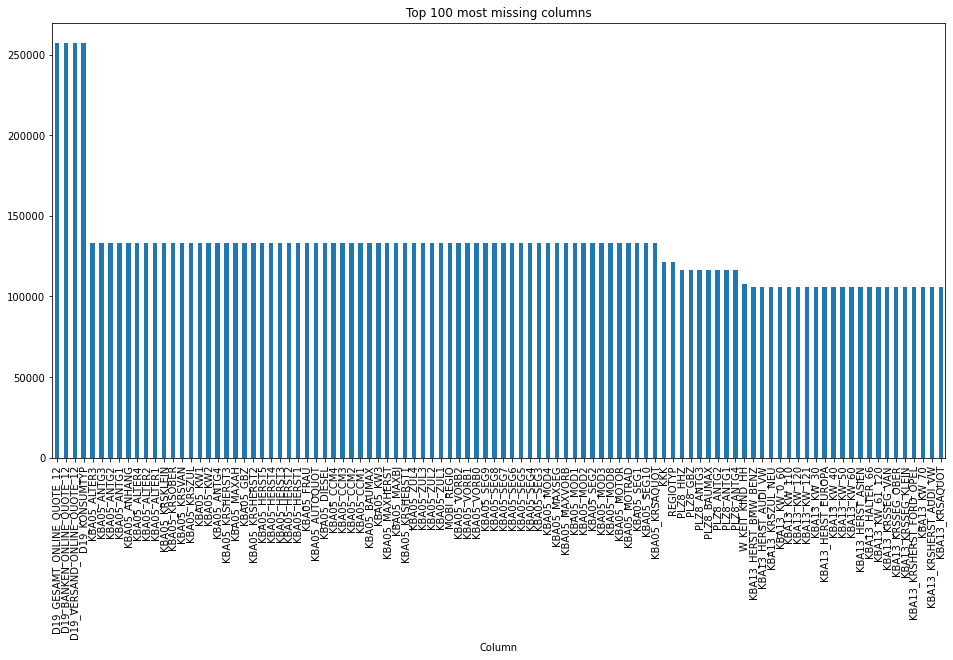

In [24]:
# plot distribution of missing values
azdias.isnull().sum().sort_values(ascending=False)[:100] \
    .plot(kind="bar", figsize=(16,8), title='Top 100 most missing columns', xlabel="Column");

For some columns, the dataset from `DIAS Information Levels - Attributes 2017.xlsx` provides properties to handle missing values.

In [25]:
# Load Excel and filter for missing values
attribute2value = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header = 1, usecols='B:E', dtype='str')
# Account for grouped rows
attribute2value = attribute2value.fillna(method='ffill')
# Print head
attribute2value.head(5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


From the attribut-values file I derive that unknowns are represented in various ways.

In [26]:
# get attribute values with meaning Unknown
attribute2value_unknowns = attribute2value[attribute2value["Meaning"].isin(["unknown","unknown / no main age detectable", "no transactions known", "no transaction known", "Universal", "no Online-transactions within the last 12 months","middle mobility"])]
attribute2value_unknowns.head(5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown


In [27]:
# set up attribute-unknown map
unknowns_map = {}
for _, row in attribute2value_unknowns.iterrows():
    key = row["Attribute"]
    # Set first value as unknown
    unknowns_map[key] = int(row["Value"].split(", ")[0])

# Manually add missing codes from remaining columns
unknowns_map["ALTERSKATEGORIE_FEIN"] = -1
unknowns_map["CAMEO_INTL_2015"] = -1
unknowns_map["CAMEO_DEUG_2015"] = -1
unknowns_map["CAMEO_DEU_2015"] = 'XX'
unknowns_map["GEBURTSJAHR"] = -1
unknowns_map["CAMEO_INTL_2015"] = -1
unknowns_map["KBA13_CCM_1401_2500"] = -1
unknowns_map["KBA13_BAUMAX"] = -1
unknowns_map["KBA13_ANTG1"] =  -1
unknowns_map["KBA13_ANTG2"] =  -1
unknowns_map["KBA13_ANTG3"] =  -1
unknowns_map["KBA13_ANTG4"] =  -1
unknowns_map["ONLINE_AFFINITAET"] = 0
unknowns_map["LP_FAMILIE_GROB"] = 0
unknowns_map["LP_STATUS_GROB"] = 0
unknowns_map["PLZ8_BAUMAX"] = -1

In [28]:
# fill nan with unknowns from above map
azdias.fillna(unknowns_map, inplace = True)

After filling unknowns using values provided by the `DIAS Attributes - Values 2017.xlsx` we see that a couple of nan-values remain. For these we impute median values.

In [29]:
# fill remaining numeric unknowns using the median
#numeric_cols = azdias.select_dtypes(include=['number']).columns
azdias.fillna(azdias.median(), inplace = True)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9156\972754089.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  azdias.fillna(azdias.median(), inplace = True)


After imputing these values, the dataset does not contain nan-values anymore.

In [30]:
# verify that dataset does not contain nulls
azdias.isnull().sum().sum()

0

In [31]:
azdias.shape

(891221, 264)

In [32]:
# saving modified azdias for further analysis
azdias.to_pickle('azdias_before_reencoding.pkl')

### Encoding categorical features

In [33]:
# loading saved dataset 
azdias = pd.read_pickle('azdias_before_reencoding.pkl')

In [34]:
# Print categorical features
azdias.select_dtypes(['object']).columns

Index(['CAMEO_DEU_2015', 'OST_WEST_KZ'], dtype='object')

CAMEO_DEU_2015:

'CAMEO_DEU_2015' contains 45 unique string values. I will convert these into a dummy matrix.

In [35]:
# Get value counts
azdias.CAMEO_DEU_2015.value_counts()

XX    99352
6B    56672
8A    52438
4C    47819
2D    35074
3C    34769
7A    34399
3D    34307
8B    33434
4A    33155
8C    30993
9D    28593
9B    27676
9C    24987
7B    24503
9A    20542
2C    19422
8D    17576
6E    16107
2B    15486
5D    14943
6C    14820
2A    13249
5A    12214
1D    11909
1A    10850
3A    10543
5B    10354
5C     9935
7C     9065
4B     9047
4D     8570
3B     7160
6A     6810
9E     6379
6D     6073
6F     5392
7D     5333
4E     5321
1E     5065
7E     4633
1C     4317
5F     4283
1B     4071
5E     3581
Name: CAMEO_DEU_2015, dtype: int64

In [36]:
# Compute dummies and merge it to azidas
azdias = pd.get_dummies(azdias, columns=['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015', dtype = np.int64, drop_first=True)

OST_WEST_KZ:

In [37]:
# Let's first have a look at the distribution
azdias.OST_WEST_KZ.value_counts()

W     629528
O     168545
-1     93148
Name: OST_WEST_KZ, dtype: int64

In [38]:
# map categorical values to integers
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1.0, 'O': -1.0})
azdias.OST_WEST_KZ.value_counts()

 1.0    629528
-1.0    168545
Name: OST_WEST_KZ, dtype: int64

In [39]:
# Drop people that could be assigned to neigher OST nor WEST
azdias.dropna(subset = 'OST_WEST_KZ', inplace=True)

In [42]:
azdias.shape

(798073, 307)

Cleaning function to re-use:

In [43]:
def clean_df(df, unknowns_map = {}, columns_to_drop = {}):
    """
    Cleans the dataframe:
    - Drop features based on azdias_not_in_attribute_list
    - Convert missing values based on unknowns_map
    - Re-encode categorical features
    
    params:
    - df (DataFrame): the Dataframe to be cleaned and preprocessed
    - unknowns_map (dict): the map containing the key-value pairs to map attribute and unknown representation
    - columns_to_drop (list): list of features to be dropped
    
    returns:
    - df_cleaned (Dataframe): to cleaned Dataframe
    """
    # drop features
    df_cleaned = df.copy()
    print('copy: {}'.format(df_cleaned.shape))
    df_cleaned = df_cleaned.drop(labels=columns_to_drop, axis=1)
    
            
    df_cleaned.loc[df_cleaned['CAMEO_DEUG_2015'] == 'X','CAMEO_DEUG_2015'] = np.nan
    df_cleaned['CAMEO_DEUG_2015'] = df_cleaned['CAMEO_DEUG_2015'].astype('float64').astype('Int64')
    
    # fill nan with unknowns from above map
    df_cleaned.fillna(unknowns_map, inplace = True)
    df_cleaned = df_cleaned.fillna(df_cleaned.median())
    
    print('fill unknowns: {}'.format(df_cleaned.shape))
    
    # Map categorical values
    df_cleaned = pd.get_dummies(df_cleaned, columns=['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015', dtype = np.int64, drop_first=True)
    
    print('map categories: {}'.format(df_cleaned.shape))
    
    df_cleaned['OST_WEST_KZ'] = df_cleaned['OST_WEST_KZ'].map({'W': 1.0, 'O': -1.0})
    
    print('map ost west: {}'.format(df_cleaned.shape))
    # Fill in NaNs after merge   
    df_cleaned.fillna(0.0, inplace=True)
    
    print('fill nans after merge: {}'.format(df_cleaned.shape))
    
    # Fix datatypes
    for column in df_cleaned.columns:
        if df_cleaned[column].dtype == (np.int64 or 'Int64'):
            df_cleaned[column] = df_cleaned[column].astype(np.float64)
    df_cleaned.CAMEO_DEUG_2015 = df_cleaned.CAMEO_DEUG_2015.astype('float64')
    
    # Print new shape and datatypes
    print("Before: {}".format(df.shape))
    print("After: {} \n".format(df_cleaned.shape))
    print("Datatypes:")
    print(df_cleaned.dtypes.value_counts())
    
    return df_cleaned

CUSTOMERS dataframe:

Customers dataset contains 3 additional columns, namely 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'. They provide details to their executed purchase in the following way:

In [44]:
customers.CUSTOMER_GROUP.value_counts()

MULTI_BUYER     132238
SINGLE_BUYER     59414
Name: CUSTOMER_GROUP, dtype: int64

In [45]:
customers.PRODUCT_GROUP.value_counts()

COSMETIC_AND_FOOD    100860
FOOD                  47382
COSMETIC              43410
Name: PRODUCT_GROUP, dtype: int64

In [46]:
customers.ONLINE_PURCHASE.value_counts()

0    174356
1     17296
Name: ONLINE_PURCHASE, dtype: int64

We won't need these columns for our analysis. Let's drop them.

In [47]:
# drop columns
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [48]:
# clean CUSTOMERS
customers_cleaned = clean_df(customers, unknowns_map, azdias_not_in_attribute_list)

copy: (191652, 366)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9156\3890798865.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cleaned = df_cleaned.fillna(df_cleaned.median())


fill unknowns: (191652, 264)
map categories: (191652, 307)
map ost west: (191652, 307)
fill nans after merge: (191652, 307)
Before: (191652, 366)
After: (191652, 307) 

Datatypes:
float64    307
dtype: int64


In [49]:
# Validate that there are no null values
customers_cleaned.isnull().sum().sum()

0

In [50]:
customers_cleaned.head(5)

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,2.0,10.0,1.0,0.0,2.0,0.0,1.0,3.0,1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,11.0,1.0,0.0,3.0,0.0,3.0,-1.0,-1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.0,6.0,1.0,0.0,1.0,0.0,3.0,7.0,5.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,8.0,0.0,0.0,0.0,0.0,1.0,7.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.0,20.0,7.0,0.0,4.0,0.0,3.0,3.0,7.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Store cleaned dataframes
azdias.to_pickle('azdias_cleaned.pkl')
customers_cleaned.to_pickle('customers_cleaned.pkl')

#### Scale features

In [52]:
# Load cleaned dataframes
azdias_cleaned = pd.read_pickle('azdias_cleaned.pkl')
customers_cleaned = pd.read_pickle('customers_cleaned.pkl')

In [53]:
# Initialize standard scaler
scaler = StandardScaler()

In [54]:
# apply Standard scaler to AZDIAS
azdias_scaled = pd.DataFrame(scaler.fit_transform(azdias_cleaned), columns = azdias_cleaned.columns)

In [55]:
# apply Standard scaler to CUSTOMERS
customers_scaled = pd.DataFrame(scaler.fit_transform(customers_cleaned), columns = customers_cleaned.columns)

In [56]:
azdias_scaled.shape

(798073, 307)

In [57]:
azdias_scaled.head(5)

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,-0.566276,-1.424283,0.173581,-0.125133,0.234464,-0.060407,-0.167017,0.846108,0.987206,0.975218,...,3.770857,-0.209106,-0.201007,-0.150063,-0.162541,-0.189537,-0.179781,-0.192766,-0.089763,-0.088513
1,-0.566276,0.802123,0.109594,-0.125133,-0.630193,-0.060407,-0.167017,-0.982545,-0.584054,-0.309681,...,-0.265192,-0.209106,-0.201007,-0.150063,-0.162541,-0.189537,-0.179781,-0.192766,-0.089763,-0.088513
2,1.870098,0.278263,-0.466293,-0.125133,-1.494851,-0.060407,-1.167128,-0.068218,-1.369684,-0.952131,...,-0.265192,-0.209106,-0.201007,-0.150063,-0.162541,-0.189537,-0.179781,-0.192766,-0.089763,-0.088513
3,-0.566276,1.195018,-0.338318,-0.125133,1.963780,-0.060407,0.833094,-0.982545,0.201576,0.975218,...,-0.265192,-0.209106,-0.201007,-0.150063,-0.162541,-0.189537,-0.179781,-0.192766,-0.089763,-0.088513
4,2.682223,-0.114632,-0.210343,-0.125133,-0.630193,-0.060407,-1.167128,0.846108,0.987206,-0.952131,...,-0.265192,-0.209106,4.974948,-0.150063,-0.162541,-0.189537,-0.179781,-0.192766,-0.089763,-0.088513


In [58]:
customers_scaled.shape

(191652, 307)

In [59]:
# For further use in Part 1 and 2
azdias_scaled.to_pickle('azdias_scaled.pkl')
customers_scaled.to_pickle('customers_scaled.pkl')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [60]:
# read pickle files from above
azdias_scaled = pd.read_pickle('azdias_scaled.pkl')
customers_scaled = pd.read_pickle('customers_scaled.pkl')

### 1 A: Dimensionality reduction: Principal Components

In [61]:
def principal_component_to_features(pca, comp_idx, column_names):
    """
    Returns dataframe with feature weights for a selected component.
    
    Input:
    pca - fitted PCA object
    component - PCA component of interest
    column_names - list of original feature names
    
    Output:
    df_features - sorted DataFrame with feature weigths
    """
    
    weights_array = pca.components_[comp_idx]
    df_features = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    return df_features.abs().sort_values(by='weight', ascending=False).round(2)

The cleaned dataset contains 307 different features. To reduce dimensions I perform principal component analysis (PCA) and reduce the dataset to most significant features.

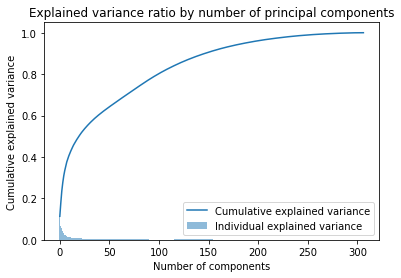

In [62]:
pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Cumulative explained variance')
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, alpha=0.5, align='center',
            label='Individual explained variance')
plt.title('Explained variance ratio by number of principal components')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.legend(loc='best')

plt.show()

We want to construct the number of features such that most of the variance is explained by the components. As a threshold, 95% is used.

In [63]:
# Define number of components such that 95% of variance is explained
n_components = (np.cumsum(pca.explained_variance_ratio_)<0.95).sum()+1
n_components

188

Of the over 300 features in the original dataset 188 can be used to explain 95% of the variance. This means the dataset can be reduced by almost half of its features while only losing 5% of variance.

In [64]:
# Perform PCA with latent features for AZDIAS
pca = PCA(n_components=n_components)
reduced_azdias = pd.DataFrame(pca.fit_transform(azdias_scaled))
print('The variance in the data explained by the principal components after employing PCA is equal to {}'.format(pca.explained_variance_ratio_.sum()))

The variance in the data explained by the principal components after employing PCA is equal to 0.9495216571736814


In [65]:
# Perform PCA with latent features for CUSTOMERS
pca = PCA(n_components=n_components)
reduced_customers = pd.DataFrame(pca.fit_transform(customers_scaled))
print('The variance in the data explained by the principal components after employing PCA is equal to {}'.format(pca.explained_variance_ratio_.sum()))

The variance in the data explained by the principal components after employing PCA is equal to 0.9800882510974389


In [66]:
reduced_azdias.shape

(798073, 188)

In [67]:
reduced_customers.shape

(191652, 188)

After PCA we reduced the dataset from 304 to `188 features` while keeping around ~`95%` of variance of the original dataset.

In [68]:
# Save reduced dataframes to pickle
reduced_azdias.to_pickle('reduced_azdias.pkl')
reduced_customers.to_pickle('reduced_customers.pkl')

**Which features do principle components stand for?**

In [69]:
# The the top 3 components explaining most of the variance
top_three_pca = pca.explained_variance_ratio_[:3]
top_three_pca

array([0.49239232, 0.03438132, 0.02524301])

In [70]:
print("The first three components explain {:.1%} of variance.".format(top_three_pca.sum()))

The first three components explain 55.2% of variance.


In [71]:
print("Component 1 explains {:.1%} of variance and is determined by: ".format(top_three_pca[0]))
principal_component_to_features(pca, 0, azdias_cleaned.columns).head()

Component 1 explains 49.2% of variance and is determined by: 


,weight
CAMEO_DEU_2015_XX,0.08
KBA13_KRSSEG_KLEIN,0.08
KBA13_KRSSEG_OBER,0.08
WOHNDAUER_2008,0.08
KBA13_KRSSEG_VAN,0.08


In [72]:
print("Component 2 explains {:.1%} of variance and is determined by: ".format(top_three_pca[1]))
principal_component_to_features(pca, 1, azdias_cleaned.columns).head()

Component 2 explains 3.4% of variance and is determined by: 


,weight
FINANZ_HAUSBAUER,0.22
LP_STATUS_FEIN,0.19
MOBI_REGIO,0.18
ONLINE_AFFINITAET,0.18
LP_STATUS_GROB,0.17


In [73]:
print("Component 3 explains {:.1%} of variance and is determined by: ".format(top_three_pca[2]))
principal_component_to_features(pca, 2, azdias_cleaned.columns).head()

Component 3 explains 2.5% of variance and is determined by: 


,weight
KBA05_SEG6,0.17
MIN_GEBAEUDEJAHR,0.15
KBA05_ANHANG,0.14
KBA05_SEG7,0.14
KBA05_SEG8,0.14


### 1 B: Segmentation: Clustering via k-means

In [74]:
# load datasets
reduced_azidas = pd.read_pickle('reduced_azdias.pkl')
reduced_customers = pd.read_pickle('reduced_customers.pkl')

In [75]:
cluster_inertia = []
for n_clusters in range(1,18):
    tic = time.perf_counter()
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(reduced_azidas)
    cluster_inertia.append(kmeans.inertia_)
    toc = time.perf_counter()
    print(f'k-means clustering for k={n_clusters} finished in {toc - tic:0.4f} seconds')

k-means clustering for k=1 finished in 11.8478 seconds
k-means clustering for k=2 finished in 33.9978 seconds
k-means clustering for k=3 finished in 46.6887 seconds
k-means clustering for k=4 finished in 69.4977 seconds
k-means clustering for k=5 finished in 66.6657 seconds
k-means clustering for k=6 finished in 113.2233 seconds
k-means clustering for k=7 finished in 116.1249 seconds
k-means clustering for k=8 finished in 139.2813 seconds
k-means clustering for k=9 finished in 149.5681 seconds
k-means clustering for k=10 finished in 140.8299 seconds
k-means clustering for k=11 finished in 177.9699 seconds
k-means clustering for k=12 finished in 204.5760 seconds
k-means clustering for k=13 finished in 188.4814 seconds
k-means clustering for k=14 finished in 236.0505 seconds
k-means clustering for k=15 finished in 274.8650 seconds
k-means clustering for k=16 finished in 275.1316 seconds
k-means clustering for k=17 finished in 244.3004 seconds


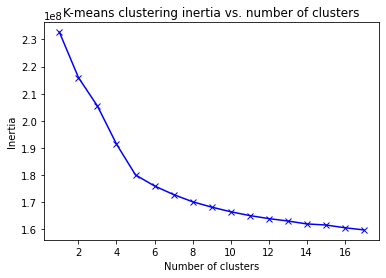

In [76]:
plt.plot(range(1,18), cluster_inertia, linestyle='-', marker='x', color='blue')
plt.title("K-means clustering inertia vs. number of clusters")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia");

From above plot we see a clear elbow at `k=5` clusters. We therefore conclude to use 5 clusters for further unsupervised learning. In case that 5 clusters are too imprecise, I will use `k=11` clusters as an alternative as this is where a linear decline in inertia starts.

### 1 C: General population vs customers

**k=5**:

In [77]:
# Fit K-Means model on azdias using 5 clusters
model = KMeans(n_clusters=5, random_state=42).fit(reduced_azidas)

Let's now use the computed clusters to compare the general population to customers.

In [78]:
azdias_predictions = model.predict(reduced_azidas)
azdias_predictions

array([3, 0, 0, ..., 0, 3, 0])

In [79]:
azdias_clustered = pd.DataFrame(azdias_predictions, columns = ['cluster'])

In [80]:
customers_predictions = model.predict(reduced_customers)
customers_predictions

array([0, 1, 3, ..., 0, 3, 0])

In [81]:
customers_clustered = pd.DataFrame(customers_predictions, columns = ['cluster'])

In [82]:
# Get cluster sizes in each dataset
population_clusters = azdias_clustered['cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['cluster'].value_counts().sort_index()

In [83]:
# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

In [84]:
# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()

In [85]:
clusters.head(5)

,cluster,population_count,customers_count,population_share,customers_share
0,1,397301,86619,0.497825,0.451960
1,2,34088,50802,0.042713,0.265074
2,3,14786,898,0.018527,0.004686
3,4,339987,53303,0.426010,0.278124
4,5,11911,30,0.014925,0.000157


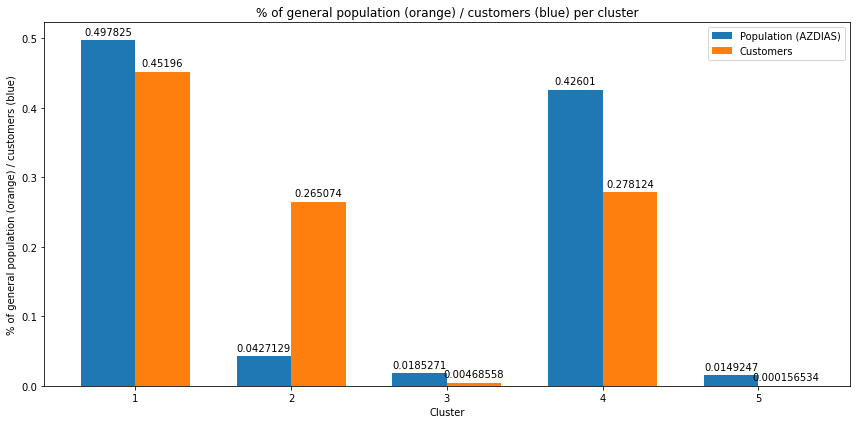

In [86]:
labels = list(clusters.cluster)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, clusters.population_share, width, label='Population (AZDIAS)')
rects2 = ax.bar(x + width/2, clusters.customers_share, width, label='Customers')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of general population (orange) / customers (blue)')
ax.set_xlabel('Cluster')
ax.set_title('% of general population (orange) / customers (blue) per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Above plot displays the distribution of the general population and customers across all clusters. We also see that ~50% of the population is grouped in the same cluster. We also see that people from cluster 3 are slightly overrepresented in the customer base, but it seems too narrow for statistical significance. From this information I conclude that the number of clusters is too low and I will redo predictions with k=11 clusters.

**k=11**:

In [87]:
# Fit K-Means model on azdias using 11 clusters
model = KMeans(n_clusters=11, random_state=42).fit(reduced_azidas)

In [88]:
azdias_predictions = model.predict(reduced_azidas)
customers_predictions = model.predict(reduced_customers)

azdias_clustered = pd.DataFrame(azdias_predictions, columns = ['cluster'])
customers_clustered = pd.DataFrame(customers_predictions, columns = ['cluster'])

# Get cluster sizes in each dataset
population_clusters = azdias_clustered['cluster'].value_counts().sort_index()
customer_clusters = customers_clustered['cluster'].value_counts().sort_index()

# Concat both dataframes to one
clusters = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
clusters.columns = ['cluster', 'population_count', 'customers_count']
clusters['cluster']+=1

# Calculate share of each cluster
clusters['population_share'] = clusters['population_count']/clusters['population_count'].sum()
clusters['customers_share'] = clusters['customers_count']/clusters['customers_count'].sum()

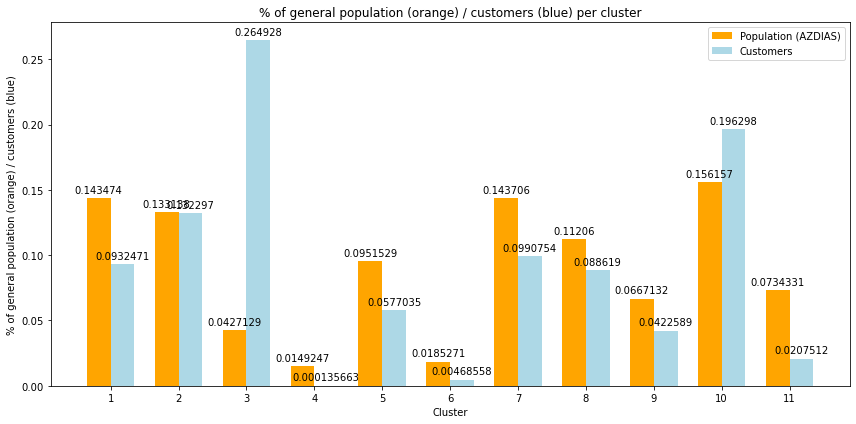

In [89]:
labels = list(clusters.cluster)

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12,6))
rects1 = ax.bar(x - width/2, clusters.population_share, width, label='Population (AZDIAS)', color='orange')
rects2 = ax.bar(x + width/2, clusters.customers_share, width, label='Customers', color='lightblue')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% of general population (orange) / customers (blue)')
ax.set_xlabel('Cluster')
ax.set_title('% of general population (orange) / customers (blue) per cluster')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

Again, above plot visualized the distribution of general population and customers across all - now 11 - clusters. We also see that clusters 3 and 10 are strongly overrepresented in the customer base, indicating that it might me useful to target people from these clusters from the general population.

### 1 D: Meaning of clusters

Above I stated that the AZDIAS dataset can be clustered into 11 different clusters. But what does this mean exactly, and is there a "typical" representant of each cluster?

In [90]:
# Get the center of cluster 1-11
centroids = model.cluster_centers_
centroids

array([[ 8.29480586e-02, -2.95757902e+00,  3.97930974e+00, ...,
         2.62949981e-02, -1.36027410e-02,  5.32296855e-02],
       [ 5.59764700e-01,  5.93768963e-01, -2.75368211e+00, ...,
        -1.18423566e-02,  1.50182904e-02, -3.32889761e-02],
       [-1.63363502e+01, -3.44343743e+00, -5.28899692e-01, ...,
        -3.32287694e-02,  3.18379444e-02, -8.73200896e-03],
       ...,
       [-4.40631055e-02, -1.29717150e+00,  7.38107915e-01, ...,
        -4.80192083e-02, -5.05627218e-02, -3.70470722e-02],
       [ 6.29310657e-01, -2.14610078e+00,  2.84691063e+00, ...,
         1.97953595e-02,  8.55440933e-04, -2.14291700e-02],
       [ 7.81866244e-02,  2.09501743e+00, -5.11849922e+00, ...,
         2.03827904e-02, -1.91037786e-02,  4.89117706e-02]])

In [91]:
# Invert PCA
X_orig = np.dot(centroids, pca.components_)
# Invert scaling
X_orig_backscaled = pd.DataFrame(scaler.inverse_transform(X_orig), columns = azdias_cleaned.columns)

In [92]:
# print centers for differnt clusters and features
X_orig_backscaled['cluster_center'] = [1,2,3,4,5,6,7,8,9,10,11]
X_orig_backscaled.set_index('cluster_center').loc[[1,3,5,10],['OST_WEST_KZ','ANZ_HAUSHALTE_AKTIV','CAMEO_DEUG_2015','ONLINE_AFFINITAET','MOBI_REGIO','ALTERSKATEGORIE_GROB','LP_LEBENSPHASE_GROB','LP_STATUS_GROB','FINANZ_ANLEGER','FINANZ_MINIMALIST','HH_EINKOMMEN_SCORE']]

,OST_WEST_KZ,ANZ_HAUSHALTE_AKTIV,CAMEO_DEUG_2015,ONLINE_AFFINITAET,MOBI_REGIO,ALTERSKATEGORIE_GROB,LP_LEBENSPHASE_GROB,LP_STATUS_GROB,FINANZ_ANLEGER,FINANZ_MINIMALIST,HH_EINKOMMEN_SCORE
cluster_center,,,,,,,,,,,
1,0.784939,-2.229532,0.929512,3.467662,4.296502,3.021414,7.075755,4.335862,1.997903,5.033304,1.115104
3,-0.225585,10.587791,-1.658086,3.129577,4.011072,1.693530,3.864991,4.317553,4.328158,3.987375,0.032041
5,0.476963,7.940290,3.972266,4.016353,2.935461,2.564762,8.444064,2.229037,3.344403,3.242704,3.766686
10,0.748273,-4.709183,1.321474,3.202593,4.653441,3.295573,7.296470,4.266595,2.783344,4.581305,1.955336


Comparing above features for overrepresented clusters (1,10) to underrepresented clusters (3,5), we see the following saliences:

Overrepresented clusters
- tend to be more in western Germany
- tend to have above-average salary
- tend to be from smaller party households, probably due to higher salaries
- have high online affinity
- tend to have higher financial literacy (invest and safe)

Underrepresented clusters
- tend to earn less
- tend to be in many-party-households
- tend to be more in eastern Germany

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
# read training data
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
# Save to pickle
# mailout_train.to_pickle('mailout_train.pkl')

In [93]:
# load pickle
mailout_train = pd.read_pickle('mailout_train.pkl')

In [94]:
# clean training data
mailout_train_clean = clean_df(mailout_train, unknowns_map, azdias_not_in_attribute_list)

copy: (42962, 367)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_9156\3890798865.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cleaned = df_cleaned.fillna(df_cleaned.median())


fill unknowns: (42962, 265)
map categories: (42962, 308)
map ost west: (42962, 308)
fill nans after merge: (42962, 308)
Before: (42962, 367)
After: (42962, 308) 

Datatypes:
float64    308
dtype: int64


In [95]:
# print responses of survey
responses_count = mailout_train_clean.RESPONSE.value_counts()
responses_count

0.0    42430
1.0      532
Name: RESPONSE, dtype: int64

<AxesSubplot:title={'center':'Distribution of responses in mailout_train_clean'}>

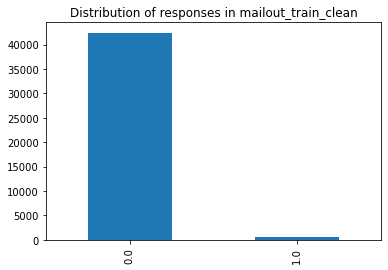

In [96]:
# plot responses of survey
responses_count.plot(kind='bar', title="Distribution of responses in mailout_train_clean")

From above plot we see that the distribution of responses is highly unbalanced and skewed towards negative responses. In this context, many classification learning algorithms have low predictive accuracy for the infrequent class. This is called the **class imbalance problem**.

#### Dealing with class imbalance

I resample the set of positive responses in a way to obtain an equal number of positive and negative responses. By that, I hope to reduce the effect.

In [97]:
# split dataset
positives = mailout_train_clean[mailout_train_clean['RESPONSE']==1] 
negatives = mailout_train_clean[mailout_train_clean['RESPONSE']==0]

In [98]:
# resample to obtain equal sample sizes
positives_balanced = resample(positives, replace=True, n_samples=len(negatives), random_state=42) 

In [99]:
# Combine balanced data sets of positive and negative responses
mailout_train_balanced = pd.concat([negatives, positives_balanced])

In [100]:
# print responses
responses_count_balanced = mailout_train_balanced.RESPONSE.value_counts()
responses_count_balanced

0.0    42430
1.0    42430
Name: RESPONSE, dtype: int64

### Predicting customer responses: training

I will perform supervised learning using a variety of supervised learning algorithms. Different algorithms are compared using the ROC AUC (area under the ROC curve) score. Each model is run 5 times (cv=5) and the best result is kept.

In [102]:
# different supervised learning classifiers
models = {'LogisticRegression': LogisticRegression(),
          'RandomForestClassifier': RandomForestClassifier(), 
          'AdaBoostClassifier': AdaBoostClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier()
         }

In [103]:
# drop response column for inputs and set response for output
X = mailout_train_balanced.drop(['RESPONSE'], axis=1)
y = mailout_train_balanced['RESPONSE']

In [104]:
# Scaling 
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X))

#### Benchmark: Logistic regression

In [105]:
# fit logistic regression classifier
grid_lr = GridSearchCV(estimator=LogisticRegression(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_lr.fit(X_train, y)

C:\Users\Lenovo\anaconda3\envs\arvato\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lenovo\anaconda3\envs\arvato\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), param_grid={},
             scoring='roc_auc')

In [106]:
# print best ROC AUC
grid_lr.best_score_

0.7642492543901869

#### Random forest

In [115]:
# fit random forest classifier 
grid_rf = GridSearchCV(estimator=RandomForestClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_rf.fit(X_train, y)

# print best ROC AUC
grid_rf.best_score_

0.9936156189432135

The result of the random forest classifier seems too high for the training data and might be the result of overfitting.

#### AdaBoost

In [116]:
# fit AdaBoost classifier
grid_ab = GridSearchCV(estimator=AdaBoostClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_ab.fit(X_train, y)

# print best ROC AUC
grid_ab.best_score_

0.7234375563272643

#### Gradient boosting

In [117]:
# fit Gradient boosting classifier
grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state = 42), param_grid={}, scoring='roc_auc', cv=5)
grid_gb.fit(X_train, y)

# print best ROC AUC
grid_gb.best_score_

0.9142034093780449

The gradient boosting model seems promising and is to be used for further model tuning.

### Model tuning

In [118]:
# set model param map
params_gb = {'max_depth': range(4,9,2),
            'n_estimators': range(20,81,10)
            }

In [119]:
# fit gradient boosting classifier with param grid
grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(random_state = 42), param_grid=params_gb, scoring='roc_auc', cv=5)
grid_gb.fit(X_train, y)

# print best ROC AUC
grid_gb.best_score_

0.9925656093031797

In [126]:
# store model
# joblib.dump(grid_gb, 'grid_gb.pkl')

['grid_gb.pkl']

In [127]:
# load model
clf = joblib.load('grid_gb.pkl')

In [129]:
# print best estimator
clf.best_estimator_

GradientBoostingClassifier(max_depth=8, n_estimators=80, random_state=42)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter.

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
# Save as pickle
#mailout_test.to_pickle('mailout_test.pkl')

In [57]:
# Load pickle
mailout_test = pd.read_pickle('mailout_test.pkl')

In [58]:
mailout_test.head(5)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [100]:
# clean test data
mailout_test_clean = clean_df(mailout_test, unknowns_map, azdias_not_in_attribute_list)

copy: (42833, 366)


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_4724\3890798865.py:27: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_cleaned = df_cleaned.fillna(df_cleaned.median())


fill unknowns: (42833, 264)
map categories: (42833, 307)
map ost west: (42833, 307)
fill nans after merge: (42833, 307)
Before: (42833, 366)
After: (42833, 307) 

Datatypes:
float64    307
dtype: int64


In [101]:
# print cleaned test data
mailout_test_clean.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,2.0,7.0,2.0,0.0,2.0,0.0,3.0,6.0,2.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,0.0,20.0,0.0,1.0,0.0,4.0,7.0,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,16.0,2.0,0.0,4.0,0.0,4.0,1.0,7.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.0,0.0,1.0,0.0,0.0,0.0,4.0,1.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,21.0,1.0,0.0,4.0,0.0,3.0,6.0,5.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [135]:
# Scaling 
scaler = StandardScaler()
X_test = pd.DataFrame(scaler.fit_transform(mailout_test_clean), columns = mailout_test_clean.columns)

In [136]:
X_test.head()

,AGER_TYP,ALTER_HH,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_PERSONEN,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CJT_GESAMTTYP,...,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,CAMEO_DEU_2015_XX
0,1.033789,-0.236176,-0.287584,-0.120872,-0.015838,-0.088595,-0.034350,0.937913,-0.595441,0.964749,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
1,-1.086712,-1.274215,1.038302,-0.120872,-0.819601,-0.088595,1.024156,1.291004,0.350607,-1.269686,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
2,1.033789,1.098445,-0.287584,-0.120872,1.591688,-0.088595,1.024156,-0.827542,0.981306,-0.711078,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
3,-1.086712,-1.274215,-0.361244,-0.120872,-1.623364,-0.088595,1.024156,-0.827542,-0.595441,0.406140,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894
4,0.326956,1.839902,-0.361244,-0.120872,1.591688,-0.088595,-0.034350,0.937913,0.350607,1.523357,...,-0.198834,-0.157203,-0.178527,-0.164834,-0.100583,-0.106906,-0.100583,-0.125292,-0.097458,-0.469894


In [139]:
# predict using trained gradient boosting model
predictions = grid_gb.predict(X_test)
predictions

C:\Users\Lenovo\anaconda3\envs\arvato\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


array([0., 0., 0., ..., 0., 0., 0.])

In [140]:
# all predictions are done
predictions.sum()

1146.0

In [141]:
# Create CSV for Kaggle submission
kaggle = pd.DataFrame({'LNR':mailout_test['LNR'].astype(np.int32), 'RESPONSE':predictions})
kaggle.to_csv('kaggle.csv', index=False)

# Conclusion

The Bertelsmann/Arvato Projest was a fun capstone project in the Data Science Nanodegree program. Handling the data load proved to be very challenging, especially cleaning and preparing the different features for further modelling steps. 

In the unsupervised learning part, customers and the general population were clustered into 11 groups. Two groups were highly present among customers compared to the general population. These two focus groups had specific characteristics: Broadly speaking, typically well-earning couples, people from west germany or families with higher education.

To forecast customer responses, the Gradient Boosting Classifier proved to be the best-performing estimator. The Kaggle submission results shows that there is still room for improvement. Possible areas for further investigation could be:

- Drop fewer or more data points when preparing the datasets.
- Test different approaches to standardize and scale features, like using Min-Max-Scaler instead of Standard Scaler.
- Choose a smaller or bigger number of clusters to group customers and population. 

I hope to return to this project to further improve forcasts.